In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#DATA_PATH = Path(r"Drug_overdose_death_rates__by_drug_type__sex__age__race__and_Hispanic_origin__United_States.csv")
sns.set_style('whitegrid')

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/joaovcar/Projeto-Machine-Learning/refs/heads/main/Drug_overdose_death_rates__by_drug_type__sex__age__race__and_Hispanic_origin__United_States.csv')
df.columns = [col.strip().lower().replace(' ', '_').replace('/', '_').replace('(', '').replace(')', '') for col in df.columns]
df['estimate'] = pd.to_numeric(df['estimate'], errors='coerce')
df['is_flagged'] = df['flag'].notna().astype(int)
df = df.drop(columns=['panel_num', 'stub_name_num', 'stub_label_num', 'year_num', 'age_num', 'flag', 'unit', 'indicator'])
df = df.dropna(subset=['estimate']).reset_index(drop=True)
print(f'Tamanho da base após limpeza: {len(df)} registros')

: 

## 1. Definição do Problema e Coleta de Dados

**Objetivo:** Desenvolver um pipeline de Machine Learning para prever a **taxa de mortalidade por overdose de drogas** (por 100.000 habitantes) nos Estados Unidos. O modelo deve ser capaz de estimar essa taxa com base em características demográficas (idade, sexo, raça/etnia) e o ano de referência.

**Tipo de Problema:** Regressão (predição de um valor numérico contínuo).

**Origem dos Dados:** Os dados são provenientes do *National Center for Health Statistics* (NCHS) e cobrem taxas de mortalidade por overdose de drogas nos EUA. O dataset inclui desagregações por tipo de droga, sexo, idade e raça/origem hispânica.
*Fonte:* [CDC/NCHS - Drug Overdose Death Rates](https://data.cdc.gov/NCHS/Drug-overdose-death-rates-by-drug-type-sex-age-rac/95ax-ymtc)

## 2. Análise Exploratória (EDA)
Nesta etapa, investigaremos a distribuição da variável alvo (`estimate`), a evolução temporal das taxas e a presença de outliers.


,panel,unit_num,stub_name,stub_label,year,age,estimate,is_flagged
0,All drug overdose deaths,1,Total,All persons,1999,All ages,6.1,0
1,All drug overdose deaths,1,Total,All persons,2000,All ages,6.2,0
2,All drug overdose deaths,1,Total,All persons,2001,All ages,6.8,0
3,All drug overdose deaths,1,Total,All persons,2002,All ages,8.2,0
4,All drug overdose deaths,1,Total,All persons,2003,All ages,8.9,0


,year,estimate
count,5117.000000,5117.000000
mean,2009.088919,4.743443
std,5.773726,6.424471
min,1999.000000,0.000000
25%,2004.000000,0.800000
50%,2009.000000,2.100000
75%,2014.000000,6.000000
max,2018.000000,54.300000


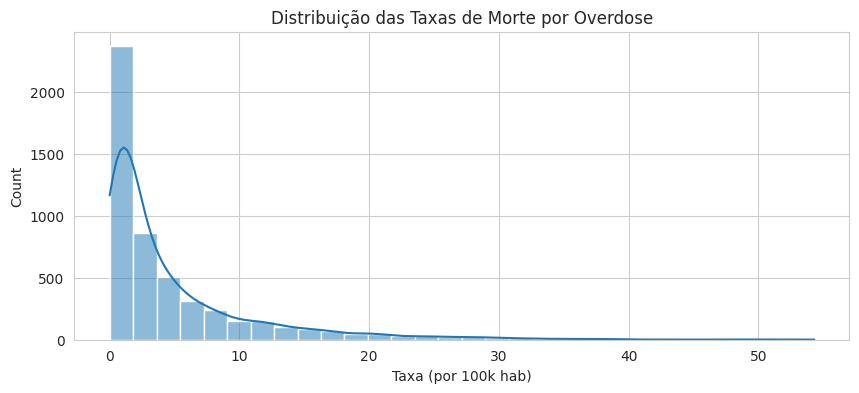

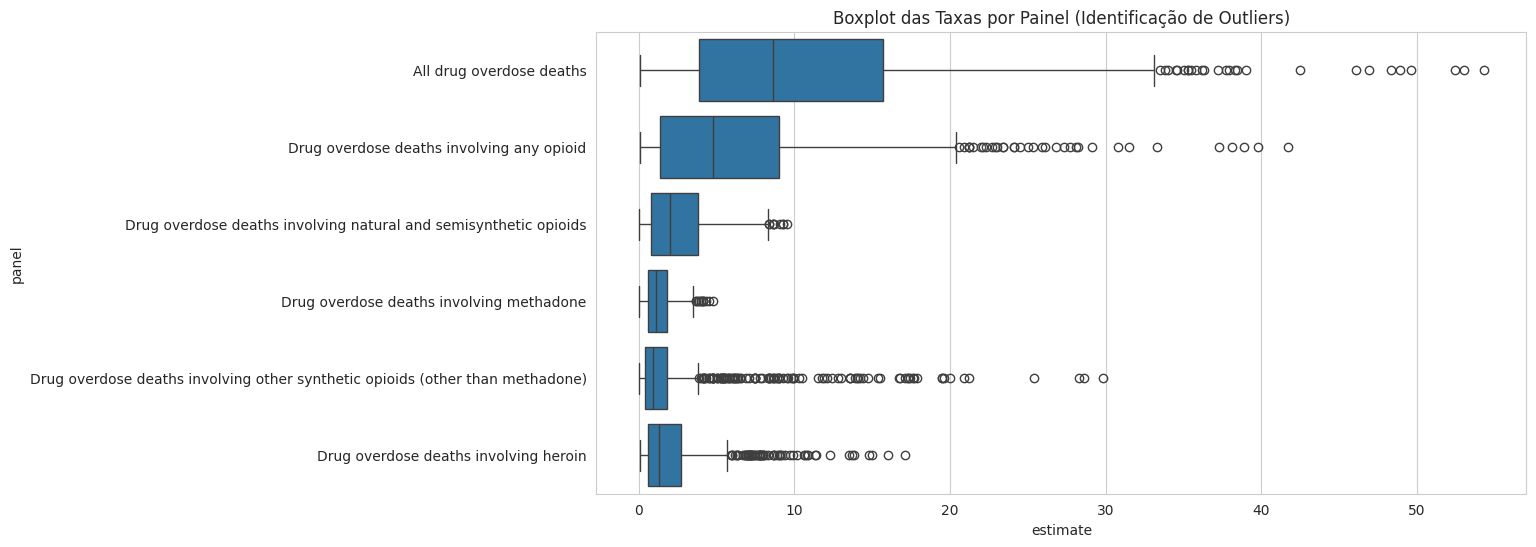

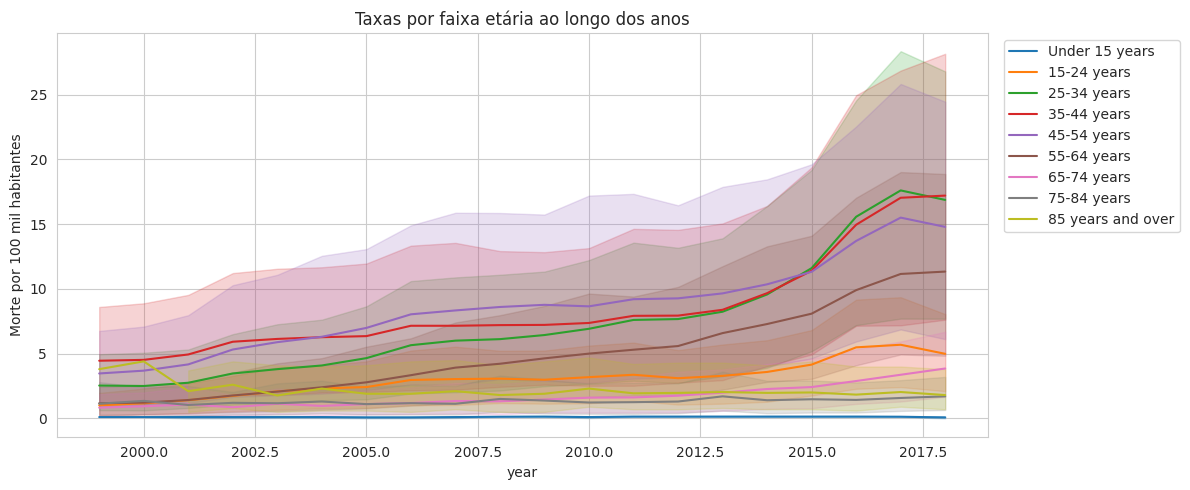

In [ ]:
display(df.head())
display(df[['year', 'panel', 'stub_label', 'estimate']].describe())

# 1. Distribuição da variável alvo
plt.figure(figsize=(10, 4))
sns.histplot(df['estimate'], bins=30, kde=True)
plt.title('Distribuição das Taxas de Morte por Overdose')
plt.xlabel('Taxa (por 100k hab)')
plt.show()

# 2. Boxplot para identificar outliers por categoria principal
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='estimate', y='panel')
plt.title('Boxplot das Taxas por Painel (Identificação de Outliers)')
plt.xlabel('Taxa de Mortalidade')
plt.ylabel('Tipo de Droga / Causa')
plt.show()

# 3. Evolução temporal por idade (Exemplo)
plt.figure(figsize=(12, 5))
sns.lineplot(data=df[df['stub_name'] == 'Age'], x='year', y='estimate', hue='stub_label')
plt.title('Taxas por faixa etária ao longo dos anos')
plt.ylabel('Morte por 100 mil habitantes')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 4. Correlação entre variáveis numéricas
plt.figure(figsize=(8, 6))
numeric_df = df.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação (Variáveis Numéricas)')
plt.show()

# 5. Taxa média por Sexo
plt.figure(figsize=(8, 5))
df_sex = df[df['stub_name'] == 'Sex']
sns.barplot(data=df_sex, x='stub_label', y='estimate', errorbar=None, palette='viridis')
plt.title('Taxa Média de Mortalidade por Sexo')
plt.ylabel('Taxa Média')
plt.xlabel('Sexo')
plt.show()


## Pré-processamento e engenharia de atributos
Vamos transformar variáveis categóricas com one-hot encoding e padronizar numéricas para alimentar modelos clássicos de regressão.

In [11]:
categorical_cols = ['panel', 'stub_name', 'stub_label', 'age']
numeric_cols = ['year', 'is_flagged']
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ('num', StandardScaler(), numeric_cols)
])
X = df[categorical_cols + numeric_cols]
y = df['estimate']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# Definição de modelos e grids de hiperparâmetros
models_config = {
    'Linear Regression': {
        'model': LinearRegression(),
        'params': {}
    },
    'Ridge (L2)': {
        'model': Ridge(),
        'params': {'model__alpha': [0.1, 1.0, 10.0, 100.0]}
    },
    'Lasso (L1)': {
        'model': Lasso(),
        'params': {'model__alpha': [0.01, 0.1, 1.0]}
    },
    'Decision Tree': {
        'model': DecisionTreeRegressor(random_state=42),
        'params': {
            'model__max_depth': [5, 10, 20, None],
            'model__min_samples_split': [2, 5, 10]
        }
    },
    'Random Forest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'model__n_estimators': [100],
            'model__max_depth': [10, 20]
        }
    }
}

results = []
best_estimators = {}

for name, config in models_config.items():
    print(f"Treinando {name}...")
    pipeline = Pipeline(steps=[('preprocess', preprocessor), ('model', config['model'])])

    # Grid Search com Cross-Validation
    grid = GridSearchCV(pipeline, config['params'], cv=5,
                        scoring='neg_mean_squared_error',
                        return_train_score=True)
    grid.fit(X_train, y_train)

    # Melhores parâmetros e modelo
    best_model = grid.best_estimator_
    best_estimators[name] = best_model

    # Avaliação no conjunto de teste
    preds = best_model.predict(X_test)

    # Métricas
    results.append({
        'model': name,
        'best_params': grid.best_params_,
        'cv_rmse_mean': np.sqrt(-grid.best_score_),
        'train_rmse': np.sqrt(mean_squared_error(y_train, best_model.predict(X_train))),
        'test_rmse': np.sqrt(mean_squared_error(y_test, preds)),
        'test_mae': mean_absolute_error(y_test, preds),
        'test_r2': r2_score(y_test, preds)
    })

results_df = pd.DataFrame(results)
display(results_df.sort_values('test_rmse'))

Treinando Linear Regression...
Treinando Ridge (L2)...
Treinando Lasso (L1)...
Treinando Decision Tree...
Treinando Random Forest...


,model,best_params,cv_rmse_mean,train_rmse,test_rmse,test_mae,test_r2
4,Random Forest,"{'model__max_depth': 20, 'model__n_estimators'...",1.536140,0.712437,1.303239,0.671929,0.961210
3,Decision Tree,"{'model__max_depth': None, 'model__min_samples...",1.579681,0.012842,1.678894,0.617969,0.935625
1,Ridge (L2),{'model__alpha': 0.1},3.526967,3.478023,3.674732,2.505236,0.691593
0,Linear Regression,{},3.526758,3.478010,3.674781,2.506058,0.691585
2,Lasso (L1),{'model__alpha': 0.01},3.563787,3.522178,3.691835,2.447451,0.688716


In [ ]:
## Validação Cruzada Temporal (Time Series Split)
Como estamos lidando com dados que possuem uma componente temporal (`year`), a validação aleatória (`train_test_split` ou `KFold` padrão) pode introduzir *data leakage*, onde o modelo aprende com dados do futuro para prever o passado.

Para garantir a robustez do modelo em um cenário real de previsão, aplicaremos o **Time Series Split**. Neste método, o conjunto de treino cresce progressivamente ao longo do tempo, e o teste é sempre realizado em um período subsequente ao treino.



In [ ]:
# Análise Detalhada de Resíduos (Melhor Modelo)
best_model_name = results_df.sort_values('test_rmse').iloc[0]['model']
best_model = best_estimators[best_model_name]

y_pred = best_model.predict(X_test)
residuals = y_test - y_pred

plt.figure(figsize=(14, 6))

# Gráfico 1: Real vs Predito
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valor Real')
plt.ylabel('Valor Predito')
plt.title(f'Real vs Predito ({best_model_name})')

# Gráfico 2: Distribuição dos Resíduos
plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True, bins=30)
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel('Resíduos (Erro)')
plt.title(f'Distribuição dos Resíduos ({best_model_name})')

plt.tight_layout()
plt.show()

# Gráfico 3: Resíduos vs Valores Preditos (Homocedasticidade)
plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Valores Preditos')
plt.ylabel('Resíduos')
plt.title('Resíduos vs Valores Preditos (Verificação de Homocedasticidade)')
plt.show()


: 

In [15]:
# Análise de Overfitting: Variação da profundidade da árvore
depths = [1, 3, 5, 10, 15, 20, 30]
train_scores = []
test_scores = []

for d in depths:
    model = DecisionTreeRegressor(max_depth=d, random_state=42)
    pipe = Pipeline(steps=[('preprocess', preprocessor), ('model', model)])
    pipe.fit(X_train, y_train)

    train_scores.append(np.sqrt(mean_squared_error(y_train, pipe.predict(X_train))))
    test_scores.append(np.sqrt(mean_squared_error(y_test, pipe.predict(X_test))))

plt.figure(figsize=(10, 5))
plt.plot(depths, train_scores, marker='o', label='Treino RMSE')
plt.plot(depths, test_scores, marker='s', label='Teste RMSE')
plt.xlabel('Profundidade da Árvore (Max Depth)')
plt.ylabel('RMSE (menor é melhor)')
plt.title('Curva de Complexidade: Overfitting vs Underfitting')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
rf_model = best_estimators['Random Forest']
tree_steps = rf_model.named_steps['preprocess']
ohe = tree_steps.named_transformers_['cat']
encoded = ohe.get_feature_names_out(categorical_cols)
feature_names = np.concatenate([encoded, numeric_cols])
importances = rf_model.named_steps['model'].feature_importances_
top10 = np.argsort(importances)[::-1][:10]
plt.figure(figsize=(10, 5))
sns.barplot(x=importances[top10], y=feature_names[top10])
plt.title('Importância das features pelo Random Forest')
plt.tight_layout()
plt.show()

## Validação com Dados Futuros (Simulação)
Para validar a capacidade de generalização do modelo, vamos simular cenários futuros (anos 2025 e 2030) e perfis demográficos específicos que não estavam explicitamente no conjunto de treino como combinações exatas (embora os valores de atributos existam). Isso simula o uso do modelo em produção para prever tendências.


In [ ]:
# Criando cenários para predição (anos futuros e perfis específicos)
# Nota: O dataset possui categorias combinadas (ex: 'Male: White'). Para prever combinações, usamos os labels correspondentes.
scenarios = [
    # Cenário 1: Previsão para 2025, Homens, Todas as idades
    {
        'year': 2025,
        'panel': 'All drug overdose deaths',
        'stub_name': 'Sex',
        'stub_label': 'Male',
        'age': 'All ages',
        'is_flagged': 0
    },
    # Cenário 2: Previsão para 2025, Mulheres, Todas as idades
    {
        'year': 2025,
        'panel': 'All drug overdose deaths',
        'stub_name': 'Sex',
        'stub_label': 'Female',
        'age': 'All ages',
        'is_flagged': 0
    },
    # Cenário 3: Previsão para 2030, Faixa etária 25-34 anos
    {
        'year': 2030,
        'panel': 'All drug overdose deaths',
        'stub_name': 'Age',
        'stub_label': '25-34 years',
        'age': '25-34 years',
        'is_flagged': 0
    },
    # Cenário 4: Previsão para 2025, Homem Branco (Categoria Combinada)
    {
        'year': 2025,
        'panel': 'All drug overdose deaths',
        'stub_name': 'Sex and race',
        'stub_label': 'Male: White',
        'age': 'All ages',
        'is_flagged': 0
    },
    # Cenário 5: Previsão para 2025, Mulher Branca (Categoria Combinada)
    # Assumindo que o label segue o padrão 'Female: White'
    {
        'year': 2025,
        'panel': 'All drug overdose deaths',
        'stub_name': 'Sex and race',
        'stub_label': 'Female: White',
        'age': 'All ages',
        'is_flagged': 0
    }
]

df_scenarios = pd.DataFrame(scenarios)

# Utilizando o melhor modelo (Random Forest) para prever
# O pipeline cuida do pré-processamento (OneHotEncoding) automaticamente
model_to_use = best_estimators['Random Forest']
predictions = model_to_use.predict(df_scenarios)

df_scenarios['Predicted_Death_Rate'] = predictions

print("Previsões do Modelo para Cenários Futuros:")
display(df_scenarios[['year', 'stub_label', 'Predicted_Death_Rate']])

# Visualização das previsões
plt.figure(figsize=(10, 5))
sns.barplot(data=df_scenarios, x='stub_label', y='Predicted_Death_Rate', hue='year')
plt.title('Previsão de Taxa de Morte por Overdose (Cenários Futuros)')
plt.ylabel('Taxa Estimada (por 100k)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 3. Análise de Séries Temporais

Nesta seção, abordaremos o problema sob a ótica de **Séries Temporais**. Diferente da regressão convencional onde o tempo foi tratado como uma feature independente, aqui consideraremos a dependência sequencial dos dados (autocorrelação).

Utilizaremos o modelo **ARIMA (AutoRegressive Integrated Moving Average)** para modelar a tendência de crescimento das taxas de mortalidade e projetar valores futuros. Focaremos na série temporal da **média das taxas de mortalidade** para o painel "All drug overdose deaths", capturando a tendência geral nacional.

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings("ignore")

# 1. Preparação dos Dados para Série Temporal
# Agregando os dados para obter uma média anual geral (Tendência Nacional)
# Filtramos pelo painel principal para evitar duplicação de contagens
ts_df = df[df['panel'] == 'All drug overdose deaths'].groupby('year')['estimate'].mean()

# Convertendo o índice para datetime (início do ano)
ts_df.index = pd.to_datetime(ts_df.index, format='%Y')
ts_df = ts_df.asfreq('AS') # AS = Year Start

# Visualização da Série Temporal
plt.figure(figsize=(12, 5))
plt.plot(ts_df.index, ts_df, marker='o', linestyle='-', linewidth=2, label='Taxa Média Observada')
plt.title('Série Temporal: Evolução da Taxa Média de Mortalidade por Overdose')
plt.xlabel('Ano')
plt.ylabel('Taxa (por 100k hab)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Visualização da Autocorrelação (ACF)
# Ajuda a identificar a dependência entre os anos
plt.figure(figsize=(10, 4))
plot_acf(ts_df, lags=10, ax=plt.gca())
plt.title('Autocorrelação (ACF)')
plt.show()

In [ ]:
# 2. Modelagem e Previsão com ARIMA
# Ajustando um modelo ARIMA(1,1,1) como ponto de partida
# p=1 (AutoRegressivo), d=1 (Diferenciação para estacionariedade), q=1 (Média Móvel)
model = ARIMA(ts_df, order=(1, 1, 1))
model_fit = model.fit()

# Resumo do Modelo
print(model_fit.summary())

# 3. Previsão para os próximos 5 anos
steps = 5
forecast_result = model_fit.get_forecast(steps=steps)
forecast_index = pd.date_range(start=ts_df.index[-1] + pd.DateOffset(years=1), periods=steps, freq='AS')
forecast_mean = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# Criando DataFrame com a previsão
forecast_df = pd.DataFrame({
    'Year': forecast_index.year,
    'Forecast': forecast_mean.values,
    'Lower CI': conf_int.iloc[:, 0].values,
    'Upper CI': conf_int.iloc[:, 1].values
})

print("\nPrevisão para os próximos anos:")
display(forecast_df)

# Visualização Final: Histórico + Previsão
plt.figure(figsize=(12, 6))

# Dados Históricos
plt.plot(ts_df.index, ts_df, label='Histórico', marker='o', color='blue')

# Previsão
plt.plot(forecast_index, forecast_mean, label='Previsão ARIMA', marker='o', color='red', linestyle='--')

# Intervalo de Confiança
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='red', alpha=0.2, label='Intervalo de Confiança 95%')

plt.title('Previsão de Taxa de Mortalidade por Overdose (ARIMA)')
plt.xlabel('Ano')
plt.ylabel('Taxa (por 100k hab)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Interpretação e Conclusão

### Descobertas Principais
- **Tendências:** A análise exploratória confirmou o aumento das taxas de overdose ao longo dos anos e diferenças significativas entre faixas etárias e tipos de drogas (painéis).
- **Modelagem:** O **Random Forest** e a **Decision Tree** (com profundidade ajustada) superaram os modelos lineares, indicando relações não-lineares complexas nos dados.
- **Regularização:** A aplicação de Ridge e Lasso ajudou a controlar a magnitude dos coeficientes nos modelos lineares, mas não foi suficiente para alcançar a performance dos modelos baseados em árvores.
- **Overfitting:** A curva de complexidade mostrou que árvores muito profundas (ex: depth > 15) tendem a overfitar (erro de treino cai, mas erro de teste estabiliza ou sobe). O GridSearch encontrou um ponto de equilíbrio.

### Limitações e Melhorias Futuras
- **Séries Temporais:** O modelo atual trata cada ano como uma observação independente. Modelos de séries temporais (ARIMA, Prophet) ou features de lag poderiam capturar melhor a dependência temporal.
- **Dados Externos:** Incluir dados socioeconômicos (desemprego, renda) poderia enriquecer a explicação das taxas.
- **Validação:** Uma validação cruzada baseada em tempo (Time Series Split) seria mais adequada para evitar vazamento de dados do futuro para o treino.